# Banknote serial number recognition

A system for banknote serial number recognition.

## Prerequsites

#### Importing modules

In [1]:
import os
import re
import glob
import random
from collections import defaultdict

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

tf.__version__

'2.1.0'

#### Configuration

In [2]:
train_locations = [
    "./dataset/SNRdataset/EUR/train",
    "./dataset/SNRdataset/JPY_1K_5K/train",
    "./dataset/SNRdataset/JPY_2K_10K/train",
    "./dataset/SNRdataset/KRW/train"
]

test_locations = [
    "./dataset/SNRdataset/EUR/test",
    "./dataset/SNRdataset/JPY_1K_5K/test",
    "./dataset/SNRdataset/JPY_2K_10K/test",
    "./dataset/SNRdataset/KRW/test"
]

BATCH_SIZE = 10

## Exploring image data

#### Loading data
Going through every directory in the dataset and loading all the images into numpy arrays using Pillow.

In [3]:
def load_data(locations: str):
    data = []
    for location in locations:
        for path in glob.glob(location + "/*"):
            image = np.array(Image.open(path).convert('L'), dtype=np.uint8)
            serial = os.path.splitext(os.path.basename(path))[0].split('_')[-1].replace('z', '')
            data.append({"image": image, "serial": serial})

    return data

In [4]:
train_data = load_data(train_locations)
test_data = load_data(test_locations)

#### Subset of the data
Plotting a random subset of 25 serial number images and their labeling to verify if they are loaded properly.

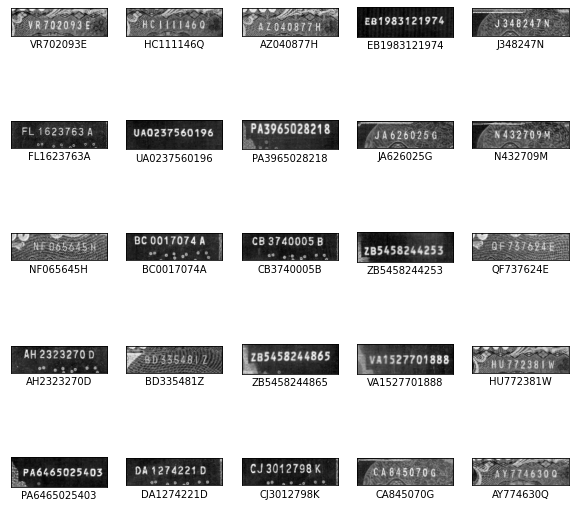

In [5]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_index = random.randint(0, len(train_data))
    plt.imshow(train_data[image_index]["image"], cmap=plt.cm.binary)
    plt.xlabel(train_data[image_index]["serial"])
plt.show()

#### Data distribution
A bar chart displaying the number of Train/Test images in each category.

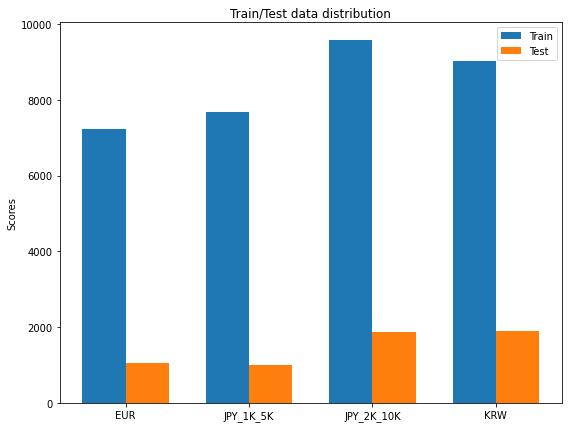

In [6]:
train_means = [len(glob.glob(path + '/*')) for path in train_locations]
test_means = [len(glob.glob(path + '/*')) for path in test_locations]

ind = np.arange(len(train_locations)) 
plt.figure(figsize=(9, 7))
width = 0.35       
plt.bar(ind, train_means, width, label='Train')
plt.bar(ind + width, test_means, width,
    label='Test')

plt.ylabel('Scores')
plt.title('Train/Test data distribution')

plt.xticks(ind + width / 2, [path.split('/')[-2] for path in train_locations])
plt.legend(loc='best')
plt.show()

#### Image resolution distribution
A bar chart containing all the image resolutions within the dataset. Whether there is more than one column, images should be resized.

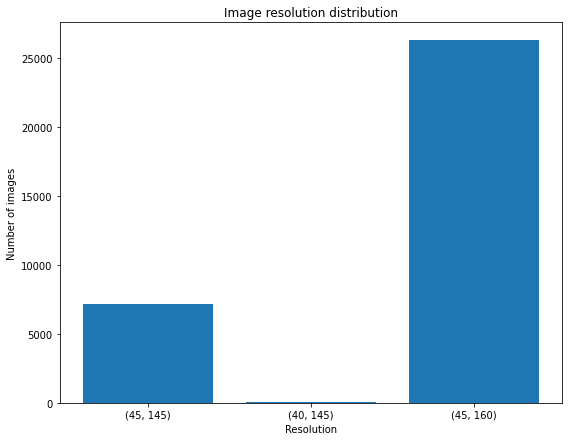

In [7]:
resolutions = defaultdict(lambda: 0)
for item in train_data:
    resolutions[item["image"].shape] += 1

x = resolutions.keys()
energy = resolutions.values()

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(9, 7))
plt.bar(x_pos, energy)
plt.xlabel("Resolution")
plt.ylabel("Number of images")
plt.title("Image resolution distribution")

plt.xticks(x_pos, x)

plt.show()

## Image data conversion

#### Convert data in numpy arrays
Loading the list data into ndarrays and resizing images for a consistent array shape.

In [8]:
def convert_to_ndarrays(dataset: list, image_size: tuple = (45, 160)):
    # Resizing images and loading them into an array
    image_array = np.array([
        cv2.resize(item["image"], dsize=image_size, interpolation=cv2.INTER_CUBIC)
        for item in dataset], dtype=np.float32)
    
    # Loading serial numbers into an array
    serials_array = np.array([item["serial"] for item in dataset])

    return image_array, serials_array

In [9]:
train_data = convert_to_ndarrays(train_data)
test_data = convert_to_ndarrays(test_data)

train_data[0].shape, train_data[1].shape

((33502, 160, 45), (33502,))

#### Loading data in a TensorFlow Dataset
Creates a shuffled, repeating 

In [10]:
def convert_to_tf_dataset(dataset: tuple, batch_size: int):
        images, serials = dataset

        # Creating a TF dataset and normilizing pixel values between 0 and 1
        tf_dataset = tf.data.Dataset.from_tensor_slices(
            (images / 255, serials))

        # Shuffling the data
        tf_dataset = tf_dataset.shuffle(len(images))

        # Repeats dataset data indefinetly
        tf_dataset = tf_dataset.repeat()

        # Batching (grouping) togheter a given number images for training
        tf_dataset = tf_dataset.batch(batch_size)

        # From TF Dataset docs (https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
        # Most dataset input pipelines should end with a call to prefetch. This allows later
        # elements to be prepared while the current element is being processed. This often improves
        # latency and throughput, at the cost of using additional memory to store prefetched
        # elements.
        tf_dataset = tf_dataset.prefetch(10)

        return tf_dataset

In [11]:
train_data = convert_to_tf_dataset(train_data, BATCH_SIZE)
test_data = convert_to_tf_dataset(test_data, BATCH_SIZE)

train_data

<PrefetchDataset shapes: ((None, 160, 45), (None,)), types: (tf.float32, tf.string)>